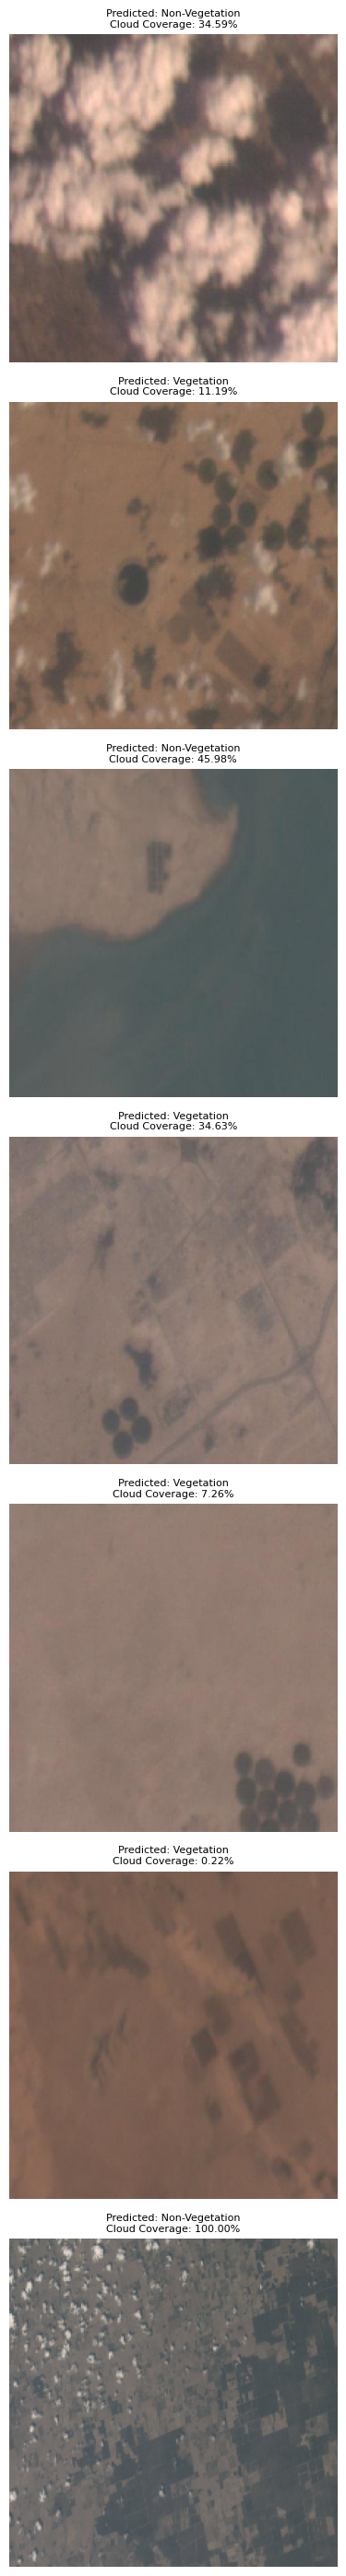

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
import cv2
from PIL import Image

# Load the TFLite model
tflite_model_path = r'C:\Users\abudh\Desktop\CropWatch\16_08_FInal\best_model_Platform1A.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Extract input shape
input_shape = input_details[0]['shape']
img_height, img_width = input_shape[1], input_shape[2]
rescale = 1.0 / 255

def load_images_from_folder(folder_path, img_height, img_width, rescale):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = keras_image.load_img(img_path, target_size=(img_height, img_width))
            img_array = keras_image.img_to_array(img) * rescale
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

# Define the cloud detection function
def calculate_cloud_coverage(image, t1=0.1, t2=0.1, kernel_size=10):
    """Calculates the cloud coverage percentage in the image."""
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    
    # Convert the image from RGB to BGR for OpenCV processing
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Extract color channels
    R = image[:, :, 2].astype(float)
    G = image[:, :, 1].astype(float)
    B = image[:, :, 0].astype(float)
    
    # Calculate ratios
    rg = R / (G + 1e-10)  # Avoid division by zero
    gb = G / (B + 1e-10)  # Avoid division by zero

    # Create a cloud mask based on color ratios
    cloud_mask1 = np.logical_and(np.abs(rg - 1) < t1, np.abs(gb - 1) < t2).astype(np.uint8)
    cloud_mask = cv2.dilate(cloud_mask1, kernel=kernel, iterations=1)
    
    # Calculate cloud coverage percentage
    cloud_cover = np.sum(cloud_mask) / cloud_mask.size * 100

    return cloud_cover

def splice_image(image):
    """Splice the image into four equal parts: top-left, top-right, bottom-left, bottom-right."""
    h, w, _ = image.shape
    mid_h, mid_w = h // 2, w // 2
    
    # Define the four parts
    top_left = image[:mid_h, :mid_w]
    top_right = image[:mid_h, mid_w:]
    bottom_left = image[mid_h:, :mid_w]
    bottom_right = image[mid_h:, mid_w:]
    
    return top_left, top_right, bottom_left, bottom_right

def save_spliced_images(image, filename, save_folder):
    """Save the four spliced parts of an image."""
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    # Splice the image
    top_left, top_right, bottom_left, bottom_right = splice_image(image)
    
    # Save each part
    Image.fromarray((top_left * 255).astype(np.uint8)).save(os.path.join(save_folder, f'{filename}_top_left.png'))
    Image.fromarray((top_right * 255).astype(np.uint8)).save(os.path.join(save_folder, f'{filename}_top_right.png'))
    Image.fromarray((bottom_left * 255).astype(np.uint8)).save(os.path.join(save_folder, f'{filename}_bottom_left.png'))
    Image.fromarray((bottom_right * 255).astype(np.uint8)).save(os.path.join(save_folder, f'{filename}_bottom_right.png'))

def save_vegetation_images(images, filenames, predicted_classes, save_folder, threshold=1):
    """Save images classified as vegetation."""
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    for img, filename, pred in zip(images, filenames, predicted_classes):
        if pred >= threshold:  # Save only vegetation images
            save_path = os.path.join(save_folder, filename)
            img_to_save = Image.fromarray((img * 255).astype(np.uint8))
            img_to_save.save(save_path)

# Load images from the test folder
test_folder = r"C:\Users\abudh\Desktop\CropWatch\Test_15_08"
test_images, test_filenames = load_images_from_folder(test_folder, img_height, img_width, rescale)

# Make predictions using the TFLite model
def predict_with_tflite_model(interpreter, images):
    predictions = []
    for img in images:
        # Prepare the image for the model
        input_data = np.expand_dims(img, axis=0).astype(np.float32)
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run the model
        interpreter.invoke()
        
        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
    
    return np.array(predictions).flatten()

# Predict class probabilities for the test images
predictions = predict_with_tflite_model(interpreter, test_images)
predicted_classes = np.round(predictions).astype(int)

# Display images with predictions and cloud coverage
num_images = len(test_filenames)
images_per_column = 10  # Adjust as needed
num_columns = (num_images + images_per_column - 1) // images_per_column

plt.figure(figsize=(num_columns * 4, images_per_column * 4))

for i in range(num_images):
    predicted_label = predicted_classes[i]
    label_str = 'Predicted: {}'.format('Vegetation' if predicted_label == 1 else 'Non-Vegetation')
    
    # Calculate cloud coverage
    cloud_coverage = calculate_cloud_coverage(test_images[i])
    label_str += f'\nCloud Coverage: {cloud_coverage:.2f}%'
    
    plt.subplot(images_per_column, num_columns, i + 1)
    plt.imshow(test_images[i])
    plt.title(label_str, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save images classified as vegetation
FILTERED_IMAGE_FOLDER = r'C:\Users\abudh\Desktop\CropWatch\Filtered_Image_Platform1'
save_vegetation_images(test_images, test_filenames, predicted_classes, FILTERED_IMAGE_FOLDER, threshold=1)

# Save spliced images of the vegetation images
SPLICED_IMAGE_FOLDER = r'C:\Users\abudh\Desktop\CropWatch\Spliced_Image_Platform1'
for img, filename, pred in zip(test_images, test_filenames, predicted_classes):
    if pred == 1:  # Only process images classified as vegetation
        save_spliced_images(img, filename, SPLICED_IMAGE_FOLDER)


Error opening image C:\Users\abudh\Desktop\CropWatch\Test_15_08\example_image.png: [Errno 2] No such file or directory: 'C:\\Users\\abudh\\Desktop\\CropWatch\\Test_15_08\\example_image.png'


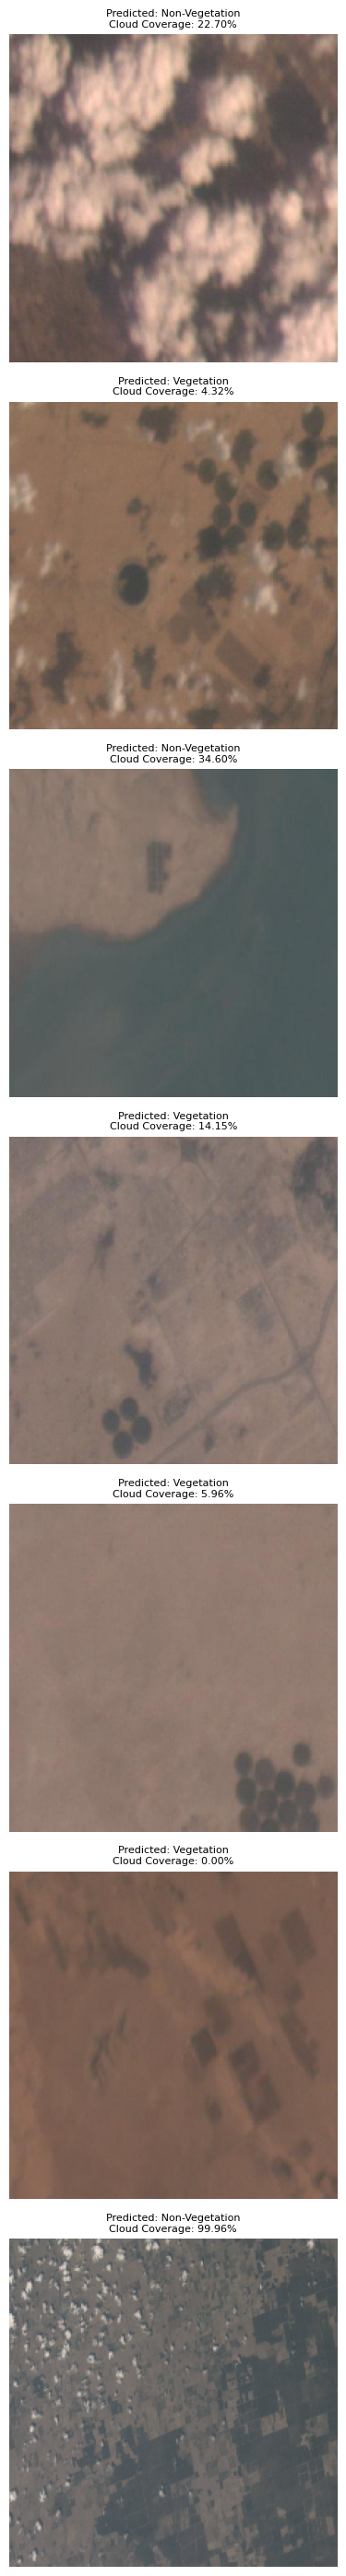

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
import cv2
from PIL import Image

# Load the TFLite model
tflite_model_path = r'C:\Users\abudh\Desktop\CropWatch\16_08_FInal\best_model_Platform1A.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Extract input shape
input_shape = input_details[0]['shape']
img_height, img_width = input_shape[1], input_shape[2]
rescale = 1.0 / 255



def load_images_from_folder(folder_path, img_height, img_width, rescale):
    """Load and preprocess images from a folder."""
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = keras_image.load_img(img_path, target_size=(img_height, img_width))
            img_array = keras_image.img_to_array(img) * rescale
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

def calculate_cloud_coverage(image, t1=0.08, t2=0.05, kernel_size=10):
    """Calculates the cloud coverage percentage in the image."""
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    
    # Convert the image from RGB to BGR for OpenCV processing
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Extract color channels
    R = image[:, :, 2].astype(float)
    G = image[:, :, 1].astype(float)
    B = image[:, :, 0].astype(float)
    
    # Calculate ratios
    rg = R / (G + 1e-10)  # Avoid division by zero
    gb = G / (B + 1e-10)  # Avoid division by zero

    # Create a cloud mask based on color ratios
    cloud_mask1 = np.logical_and(np.abs(rg - 1) < t1, np.abs(gb - 1) < t2).astype(np.uint8)
    cloud_mask = cv2.dilate(cloud_mask1, kernel=kernel, iterations=1)
    
    # Calculate cloud coverage percentage
    cloud_cover = np.sum(cloud_mask) / cloud_mask.size * 100

    return cloud_cover

def save_vegetation_images(images, filenames, predicted_classes, save_folder, threshold=1):
    """Save images classified as vegetation."""
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    for img, filename, pred in zip(images, filenames, predicted_classes):
        if pred >= threshold:  # Save only vegetation images
            save_path = os.path.join(save_folder, filename)
            img_to_save = Image.fromarray((img * 255).astype(np.uint8))
            img_to_save.save(save_path)

def predict_with_tflite_model(interpreter, images):
    """Predict class probabilities for the given images using the TFLite model."""
    predictions = []
    for img in images:
        # Prepare the image for the model
        input_data = np.expand_dims(img, axis=0).astype(np.float32)
        
        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run the model
        interpreter.invoke()
        
        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0])
    
    return np.array(predictions)

# Load images from the test folder
test_folder = r"C:\Users\abudh\Desktop\CropWatch\Test_15_08"
test_images, test_filenames = load_images_from_folder(test_folder, img_height, img_width, rescale)

# Predict class probabilities for the test images
predictions = predict_with_tflite_model(interpreter, test_images)
predicted_classes = np.round(predictions).astype(int)

# Display images with predictions and cloud coverage
num_images = len(test_filenames)
images_per_column = 10  # Adjust as needed
num_columns = (num_images + images_per_column - 1) // images_per_column

plt.figure(figsize=(num_columns * 4, images_per_column * 4))

for i in range(num_images):
    predicted_label = predicted_classes[i]
    label_str = 'Predicted: {}'.format('Vegetation' if predicted_label == 1 else 'Non-Vegetation')
    
    # Calculate cloud coverage
    cloud_coverage = calculate_cloud_coverage(test_images[i])
    label_str += f'\nCloud Coverage: {cloud_coverage:.2f}%'
    
    plt.subplot(images_per_column, num_columns, i + 1)
    plt.imshow(test_images[i])
    plt.title(label_str, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save images classified as vegetation
FILTERED_IMAGE_FOLDER = r'C:\Users\abudh\Desktop\CropWatch\Filtered_Image_Platform111'
save_vegetation_images(test_images, test_filenames, predicted_classes, FILTERED_IMAGE_FOLDER, threshold=1)


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
import cv2
from PIL import Image

# Load the TFLite model and allocate tensors
tflite_model_path = r'C:\Users\abudh\Desktop\CropWatch\16_08_FInal\best_model_Platform1A.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details from the model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Extract input shape and define image dimensions
input_shape = input_details[0]['shape']
img_height, img_width = input_shape[1], input_shape[2]
rescale = 1.0 / 255.0defload_images_from_folder(folder_path, img_height, img_width, rescale):
    """Load and preprocess images from a folder."""
    images, filenames = [], []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = keras_image.load_img(img_path, target_size=(img_height, img_width))
            img_array = keras_image.img_to_array(img) * rescale
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

defcalculate_cloud_coverage(image, t1=0.08, t2=0.05, kernel_size=10):
    """Calculate the cloud coverage percentage in the image."""
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    
    # Convert image to BGR for OpenCV processing
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    # Extract color channels and calculate ratios
    R, G, B = image[:, :, 2].astype(float), image[:, :, 1].astype(float), image[:, :, 0].astype(float)
    rg, gb = R / (G + 1e-10), G / (B + 1e-10)  # Avoid division by zero# Create a cloud mask based on color ratios
    cloud_mask = np.logical_and(np.abs(rg - 1) < t1, np.abs(gb - 1) < t2).astype(np.uint8)
    cloud_mask = cv2.dilate(cloud_mask, kernel=kernel, iterations=1)
    
    # Calculate and return cloud coverage percentagereturn np.mean(cloud_mask) * 100defsave_vegetation_images(images, filenames, predicted_classes, save_folder, threshold=1):
    """Save images classified as vegetation."""
    os.makedirs(save_folder, exist_ok=True)
    for img, filename, pred inzip(images, filenames, predicted_classes):
        if pred >= threshold:  # Save only vegetation images
            save_path = os.path.join(save_folder, filename)
            Image.fromarray((img * 255).astype(np.uint8)).save(save_path)

defpredict_with_tflite_model(interpreter, images):
    """Predict class probabilities for the given images using the TFLite model."""
    predictions = []
    for img in images:
        input_data = np.expand_dims(img, axis=0).astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        predictions.append(interpreter.get_tensor(output_details[0]['index'])[0])
    return np.array(predictions)

# Load images from the test folder
test_folder = r"C:\Users\abudh\Desktop\CropWatch\Test_15_08"
test_images, test_filenames = load_images_from_folder(test_folder, img_height, img_width, rescale)

# Predict class probabilities for the test images
predictions = predict_with_tflite_model(interpreter, test_images)
predicted_classes = np.round(predictions).astype(int)

# Display images with predictions and cloud coverage
num_images = len(test_filenames)
images_per_column = 10
num_columns = (num_images + images_per_column - 1) // images_per_column

plt.figure(figsize=(num_columns * 4, images_per_column * 4))

for i, (img, label) inenumerate(zip(test_images, predicted_classes)):
    cloud_coverage = calculate_cloud_coverage(img)
    label_str = f'Predicted: {"Vegetation"if label == 1else"Non-Vegetation"}\nCloud Coverage: {cloud_coverage:.2f}%'
    
    plt.subplot(images_per_column, num_columns, i + 1)
    plt.imshow(img)
    plt.title(label_str, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save images classified as vegetation
FILTERED_IMAGE_FOLDER = r'C:\Users\abudh\Desktop\CropWatch\Filtered_Image_Platform111'
save_vegetation_images(test_images, test_filenames, predicted_classes, FILTERED_IMAGE_FOLDER)


SyntaxError: invalid decimal literal (4174363589.py, line 21)